# Тестовое задание на позицию Product Analyst, Aviasales
## Подготовлено: Богдан Романов

<br>

### 1 Задание
У нас есть кусочек исследования, который мы теперь хотим поставить на регулярное выполнение. Пожалуйста, перепиши код, отформатировав его для удобства дальнейшего переиспользования и исправив ошибки, если они есть.

Подгружаем все необходимые пакеты и модули. В отличие от изначального кода, неиспользуемые модули не подгружаются.

In [1]:
# 1st task
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# 2nd task
import seaborn as sns
import warnings

sns.set(rc={'figure.figsize':(25,9)})

warnings.filterwarnings("ignore")

Поскольку задание не предполагает доступа к БД, я решил сгенерировать данные, чтобы проверить хоть какую-то работоспособность кода. В частности, проверяться будут визуализации.

In [2]:
def generate_mock_data(seed, num_days=15):
    """
    Generate a mock dataset for bookings and profits over a specified date range. Structure is taken from the Aviasales tasks.

    Parameters:
    - seed (int): Seed for the random number generator. This ensures reproducibility of the generated data.
    - num_days (int, optional): Number of days for which data is to be generated. Default is 15.

    Returns:
    - DataFrame: A pandas DataFrame containing the following columns:
        * 'period': Dates for the specified number of days.
        * 'total_bookings_aviasales': Randomly generated total bookings for each day.
        * 'total_profit_aviasales': Randomly generated profit values for each day.
        * 'pdate': Dates for the specified number of days (similar to 'period').
        * 'bookings': Randomly generated bookings for each day.
        """

    np.random.seed(seed)
    date_range = [(datetime.today() - timedelta(days=i)).date() for i in range(num_days)]
    data = {
        'period': date_range,
        'total_bookings_aviasales': np.random.randint(1000, 9999, size=num_days),
        'total_profit_aviasales': np.random.random(size=num_days) * 1000,
        'pdate': date_range,
        'bookings': np.random.randint(500, 2000, size=num_days),
    }
    return pd.DataFrame(data)

booking_data = generate_mock_data(seed=42)
profit_data = booking_data.copy()
sender_data = generate_mock_data(seed=24)
sender_data_last_year = generate_mock_data(seed=7)

df_merged = profit_data.copy()
df_merged['total_profit_aviasales_forc'] = df_merged['total_profit_aviasales']*2 + df_merged['total_profit_aviasales']**2
df_yesterday = df_merged.copy()
df_yesterday['period'] = (pd.to_datetime(df_yesterday['period']) - timedelta(days=1)).dt.strftime('%Y-%m-%d')
df_merged = df_merged.merge(df_yesterday, left_on='period', right_on='period', how='left')
df_merged = df_merged.sort_values(by='period').reset_index(drop=True)

booking_data.head()

,period,total_bookings_aviasales,total_profit_aviasales,pdate,bookings
0,2023-10-09,8270,992.211559,2023-10-09,1146
1,2023-10-08,1860,617.481510,2023-10-08,520
2,2023-10-07,6390,611.653160,2023-10-07,1340
3,2023-10-06,6191,7.066305,2023-10-06,666
4,2023-10-05,6734,23.062425,2023-10-05,1797


Функция для инициации сессии подключения к БД. На самом деле, она может быть лишнией, но поскольку я не знаю схему организации БД и связей между датасетами, то я её написал, но закоментировал.

In [3]:
# def initiate_session(database_url):
#     """
#     Initialize a session for the given database URL using SQLAlchemy.
#     This function creates an engine for the provided database URL and prepares a session factory that can be
#     used to create individual sessions for database interactions.
#
#     Parameters:
#     - database_url (str): The database URL string used to connect to the database.
#                           It should contain necessary details like dialect, username, password, hostname, port, and database name.
#
#     Returns:
#     - SessionLocal (sessionmaker): A factory that can be used to create individual sessions for database interactions.
#     """

#     engine = create_engine(database_url)
#     SessionLocal = sessionmaker(bind=engine)
#     return SessionLocal

In [ ]:
DATABASE_URL = 'database_url'
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(bind=engine)

Функция для расчёта всех необходимых дат для запроса данных из БД.

In [5]:
def compute_dates(datetime_format):
    """
    Compute a collection of specific dates relative to the current date.
    This function calculates a set of dates, including yesterday, two days ago, a week ago,
    two weeks ago, the day after a week ago, and the same day in the previous year. Each date
    is converted to a string format based on the provided format parameter.

    However, the function operates under the assumption that date objects are predefined.

    Parameters:
    - datetime_format (str): A string that dictates the datetime format for converting date objects.

    Returns:
    - dict: A dictionary containing the following key-value pairs:
        * 'yesterday': Date string for the previous day.
        * 'two_days_ago': Date string for two days prior.
        * 'week_ago': Date string for a week ago.
        * 'two_weeks_ago': Date string for two weeks ago.
        * 'last_week': Date string for the day following one week ago.
        * 'last_year': Date string for the same calendar day in the previous year.
    """

    today_dt = datetime.today().date()
    yesterday_dt = today_dt - timedelta(days=1)
    two_days_ago_start = (today_dt - timedelta(days=2))
    week_ago_start = (today_dt - timedelta(days=7))
    two_weeks_ago_start = (today_dt - timedelta(days=14))
    last_week_day = (today_dt - timedelta(days=8))
    last_year_day = (yesterday_dt - relativedelta(years=1))

    return {
        'yesterday': yesterday_dt.strftime(datetime_format),
        'two_days_ago': two_days_ago_start.strftime(datetime_format),
        'week_ago': week_ago_start.strftime(datetime_format),
        'two_weeks_ago': two_weeks_ago_start.strftime(datetime_format),
        'last_week': last_week_day.strftime(datetime_format),
        'last_year': last_year_day.strftime(datetime_format)
    }

Как только мы разобрались с вводными данными, можно перейти к запросам данных из БД.

In [7]:
def fetch_bookings_data(session, start_date, end_date):
    """
    Fetch the total bookings from the 'bd.bookings' table for a given date range.

    This function queries the database for the total number of bookings made between the
    provided start and end dates. The results are grouped by the booking date and sorted in ascending order.

    Parameters:
    - session (Session): An active SQLAlchemy session to query the database. Here it is set up within the initiate_session() function
    - start_date (str): The start date of the range for which bookings data should be fetched.
    - end_date (str): The end date of the range for which bookings data should be fetched.

    Returns:
    - DataFrame: A pandas DataFrame containing two columns:
        * 'period': The date on which bookings were made.
        * 'total_bookings_aviasales': The total number of bookings made on that date.
    """

    booking_query = """
    SELECT to_date(booked_at) AS period, count(booking_id) AS total_bookings_aviasales
    FROM bd.bookings
    WHERE to_date(booked_at) BETWEEN :start_date AND :end_date
    GROUP BY to_date(booked_at)
    ORDER BY to_date(booked_at)
    """

    result = session.execute(text(booking_query), {'start_date': start_date, 'end_date': end_date})
    booking_df = pd.DataFrame(result.fetchall(), columns=['period', 'total_bookings_aviasales'])

    return booking_df

In [8]:
def fetch_profit_data(session, start_date, end_date):
    """
    Fetch the total profit data from the 'bd.bookings' table for a given date range.

    This function queries the database for the total profit generated between the
    provided start and end dates. The results are grouped by the date and sorted in ascending order.

    Parameters:
    - session (Session): An active SQLAlchemy session to query the database. Here it is set up within the initiate_session() function
    - start_date (str): The start date of the range for which profit data should be fetched.
    - end_date (str): The end date of the range for which profit data should be fetched.

    Returns:
    - DataFrame: A pandas DataFrame containing two columns:
        * 'period': The date on which profit generated.
        * 'total_profit_aviasales': The total profit generated on that date.
    """

    profit_query = """
    SELECT to_date(booked_at) AS period, sum(profit) AS total_profit_aviasales
    FROM bd.bookings
    WHERE to_date(booked_at) BETWEEN :start_date AND :end_date
    GROUP BY to_date(booked_at)
    ORDER BY to_date(booked_at)
    """

    result = session.execute(text(profit_query), {'start_date': start_date, 'end_date': end_date})
    profit_df = pd.DataFrame(result.fetchall(), columns=['period', 'total_profit_aviasales'])

    return profit_df

In [9]:
def fetch_sender_data(session, start_date, end_date):
    """
    Fetch the sender-specific booking data from the 'bd.bookings' table for a given date range.

    This function queries the database for the count of bookings made by specific senders (identified by sender_ids)
    between the provided start and end dates. The results are grouped by the date and sorted in ascending order.

    Parameters:
    - session (Session): An active SQLAlchemy session to query the database. This session is typically set up within the initiate_session() function.
    - start_date (str): The start date of the range for which sender-specific booking data should be fetched.
    - end_date (str): The end date of the range for which sender-specific booking data should be fetched.

    Returns:
    - DataFrame: A pandas DataFrame containing the following columns:
        * 'booked_at': The date on which bookings were made.
        * 'booking_sender': The number of bookings made by the specified senders on that date.
        * 'bookings': The total number of bookings made on that date.
        * 'share_of_sender_bookings': The percentage share of bookings made by the specified senders out of the total bookings on that date.
    """

    sender_query = """
    SELECT booked_at,
        count(CASE WHEN sender_id IN (10, 20, 30) THEN booking_id ELSE NULL END) AS booking_sender,
        count(booking_id) AS bookings,
        count(CASE WHEN sender_id IN (10, 20, 30) THEN booking_id ELSE NULL END) * 100 / count(booking_id) AS share_of_sender_bookings
    FROM bd.bookings
    WHERE to_date(booked_at) BETWEEN :start_date AND :end_date
    GROUP BY to_date(booked_at)
    ORDER BY to_date(booked_at)
    """

    result = session.execute(text(sender_query), {'start_date': start_date, 'end_date': end_date})
    sender_df = pd.DataFrame(result.fetchall(), columns=['booked_at', 'booking_sender', 'bookings', 'share_of_sender_bookings'])

    return sender_df

Последняя функция, функция для визуализаций!

In [10]:
def produce_visualizations(df_booking, df_profit, df_sender, df_sender_last_year):
    """
    Produce visualizations based on the booking, profit, and sender data.

    This function creates four visualizations:
    1. Total Bookings Aviasales
    2. Total Profit Aviasales
    3. Sender Bookings
    4. Sender Bookings for the previous year

    Parameters:
    - booking_data (DataFrame): Data related to total bookings. Expected columns: ['period', 'total_bookings_aviasales'].
    - profit_data (DataFrame): Data related to total profit. Expected columns: ['period', 'total_profit_aviasales'].
    - sender_data (DataFrame): Data related to sender bookings. Expected columns: ['pdate', 'bookings'].
    - sender_data_last_year (DataFrame): Data related to sender bookings for the previous year. Expected columns: ['pdate', 'bookings'].

    Returns:
    None. This function produces visualizations and displays them using plt.show().

    Note:
    This function assumes that a global variable 'df_merged' exists and contains a 'period' column to indicate the last date.
    """

    fig, axs = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.525, wspace=0.225)
    fig.suptitle('Charts', fontsize=14)

    graphs_info = {
        'Total Bookings Aviasales': {
            'data': df_booking,
            'x': 'period',
            'y': 'total_bookings_aviasales',
            'ylabel': 'Total Bookings'
        },
        'Total Profit Aviasales': {
            'data': df_profit,
            'x': 'period',
            'y': 'total_profit_aviasales',
            'ylabel': 'Total Profit'
        },
        'Sender Bookings': {
            'data': df_sender,
            'x': 'pdate',
            'y': 'bookings',
            'ylabel': 'Bookings'
        },
        'Sender Bookings year': {
            'data': df_sender_last_year,
            'x': 'pdate',
            'y': 'bookings',
            'ylabel': 'Bookings'
        }
    }

    for ax, (title, graph_info) in zip(axs.flat, graphs_info.items()):
        df = graph_info['data']
        x_col, y_col = graph_info['x'], graph_info['y']

        ax.plot(df[x_col], df[y_col], marker='o')
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.set_ylabel(graph_info['ylabel'])
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

        last_date = df_merged['period'].iloc[-1]
        ax.plot(
            last_date,
            df[df[x_col] == last_date][y_col],
            marker='o', markersize=8, label='Last Date', color='red', markeredgewidth=2
        )

    plt.show()

Общая утилитарная функция для всего пайплайна.

In [11]:
def main():
    """
    Main function to fetch booking-related data and produce visualizations.

    This function:
    1. Computes relevant date ranges.
    2. Initiates a database session.
    3. Fetches booking data, profit data, sender-specific booking data, and sender-specific booking data from the previous year using the session.
    4. Generates visualizations based on the fetched data.

    No parameters are taken by this function, and it doesn't return anything. Instead, it executes the described actions when called.
    """

    dates = compute_dates('%Y-%m-%d')

    with SessionLocal() as session:
        booking_df = fetch_bookings_data(session, dates['two_weeks_ago'], dates['yesterday'])
        profit_df = fetch_profit_data(session, dates['two_weeks_ago'], dates['yesterday'])
        sender_df = fetch_profit_data(session, dates['two_weeks_ago'], dates['yesterday'])
        sender_df_last_year = fetch_profit_data(session, dates['last_year'], dates['yesterday'])[2]

        produce_visualizations(booking_df, profit_df, sender_df, sender_df_last_year)

Пример работы "новых" графиков!

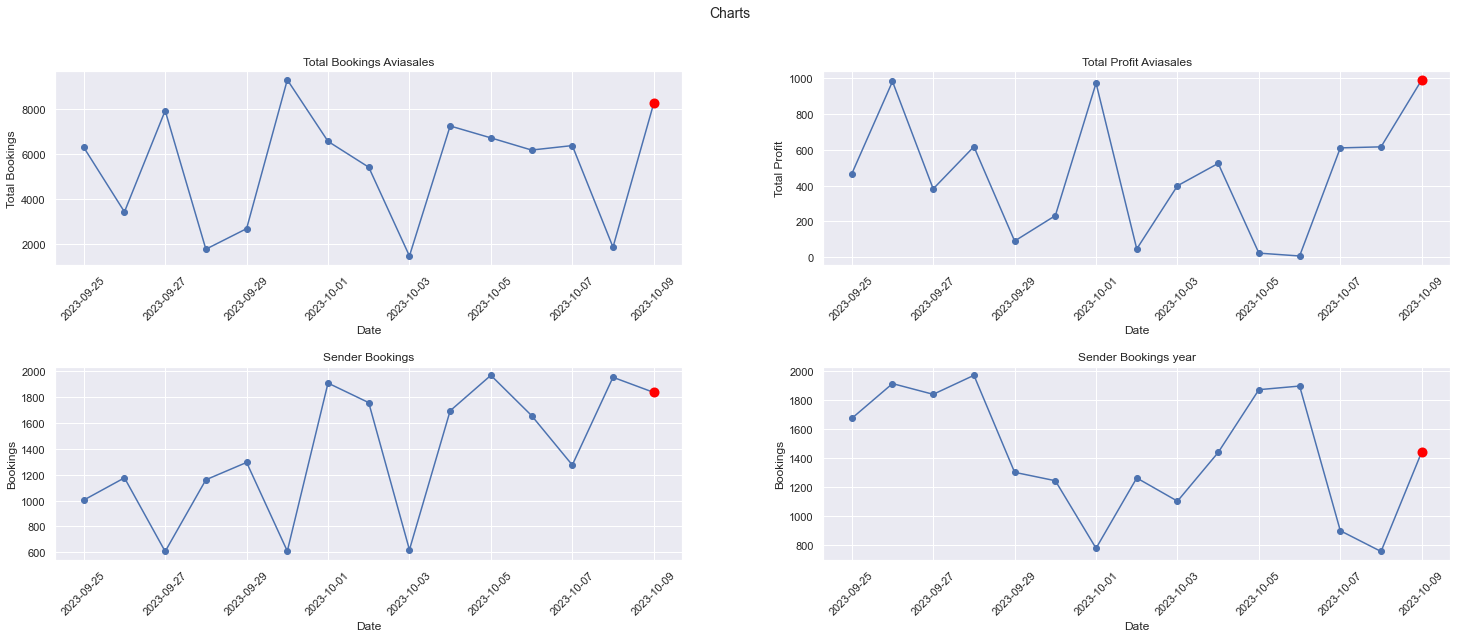

In [12]:
produce_visualizations(booking_data, profit_data, sender_data, sender_data_last_year)

## Заключение

Хотелось бы резюмировать, что именно я изменил в коде с точки зрения общей логики и оптимизации.
1. Разбиение кода на смысловые блоки и обрамление логики в соответствие с принципами ООП. Изначальный код был помещен в одну ячейку, чтобы могло вызвать проблему с отслеживанием ошибок и, что самое главное, с читаемостью.
2. Сами запросы данные я вынес тоже в функции и при этом сделал их более надежными и безопасными, убрав f-строки и тем самым sql injection. Плюс, я одной функцией покрыл сразу два запроса данных, в то время как в оригинальном коде, для каждых данных совершался отдельный запрос.
3. Переписал логику визуализации, увеличив читаемость. Конкретный пример, вложенный цикл с ответвлением в elif, которые невероятно длинные и нечитаемые. Плюс, изменил настройки в графиках, чтобы не было наложения подписей!
4. Из мелочей, местами улучшил быстродействие, например:
- `data_copy['total_profit_aviasales_forc'] = data_copy.apply(lambda row: row['total_profit_aviasales'] * 2 + np.sqrt(row['total_profit_aviasales']), axis=1)`
   Возможно я чего-то не понимаю в жизни, но вызов лямбды можно убрать и применить функции квадрата и квадратного корня сразу к столбцам.
   `df_merge[‘total_profit_aviasales’]*2 + df_merge[‘total_profit_aviasales’]**2`
- Снизил количество создаваемых объектов, например, с датами.
5. Учитывая, что я не знаю, кто будет работать с кодом, я чуть-чуть упростил части GROUP BY, ORDER BY, заменив номер переменной в выборе значений, на название столбца.
6. Док строки для функций я написал на английском, потому что Aviasales раньше код выкладывался на GitHub с английской документацией. И да, мой код на GitHub не обладает столь подробным описанием, поскольку зачастую там проекты, над которыми работю только я.


Мне не очень нравится функция `fetch_sender_data`, как будто её можно было сделать более гибкой, например, если вынести кортеж `sender_ids - (10, 20, 30)` -  в параметр функции. Но тогда схожие настройки можно было сделать и для других функций.

<br>

<br>

# 2 Задание
В поисковую выдачу билетов была разработана и внедрена скоринговая модель, ранжирующая билеты.
Ее цель - помочь пользователю выбрать лучший авиабилет самым быстрым способом, подняв его в топ выдачи.

Пожалуйста, внимательно изучи поисковую выдачу сайта и предложи:

1. Какими метриками бы ты отслеживал качество работы модели?

2. Какие визуализации могли бы помочь быстро подсветить проблему и разобраться менеджерам, что пошло не так?

3. Что важно учесть и какие срезы стоит смотреть отдельно?

4. Какие данные тебе нужны, чтобы все это сделать?


Для выполнения задания ты можешь самостоятельно сгенерировать данные с учетом ожидаемых распределений или просто описать ход своей работы.

## Введение

Сперва, когда я ознакомился с текстом задания, мне показалось, что оно про оценку модели в качестве бинарного ранжирования -- билет либо в топе (оптимальный в плане цены и прочих параметров), либо нет. Для этого нужно было бы использовать относительно технические методы работы модели -- ROC AUC значение у разных параметров и смежные метрики в духе precision-recall.

Но вспомнив, куда я подавался в первую очередь, переключился на продуктовые показатели, которые так или иначе можно собирать с сайта. Структура решения проста: сперва я расскажу, (1) какие метрики можно отслеживать, чтобы оценивать работу скоринговой модели; (2) какие визуализации можно использовать и автоматизировать, чтобы регулярно оценивать работу модели "на глаз"; (3) какие экстернальные нюансы могут повлиять на качество модели; (4) и в заключении предположу, какие данные необходимы для этого всего.

![OUTPUT_EXAMPLE](photo_2023-10-08_15-35-35.jpg)

## 1. Метрики качества работы модели
**Click-Through Rate** -- самая прямолинейная метрика, это показатель того, как часто пользователи кликают на высокоранжированные билеты (отношение числа кликов на билеты к числу показов, impressions). Формально, если пользователь, после ознакомления с выдачей, нажимает на первые три билета ("Самый..."), то это может быть показателем, что модель работает хорошо и действительно выбирает оптимальные билеты. В противном случае, если же пользователь скролит ниже или даже нажимает на "Показать ещё 10 билетов", то это может сигнализировать либо билеты были выбраным некорректно, либо пользователь не настроил свой запрос, поэтому он и ищет что-то ещё.

**Конверсия в продажу** -- продолжение CTR метрики, только теперь мы анализируем не только куда кликает пользователь, но и берём в расчёт его/её сессию на сайте. Если пользователь после клика на один из трёх высокоранжированных переходит на один из партнёрских сайтов, то мы можем это интерпретировать как "покупку". Я пишу в кавычках, потому что мне кажется, что как только пользователь покидает сайт, то у нас уже нет информации о его операциях. Поэтому мы не можем быть уверен, что покупка была произведена.
- **Отношение конверсии** -- подметрика общей конверсии показывающая относительное значение процента пользователей, которые совершили покупку после клика на первые результаты (любой из "Самый..."), с теми, кто совершил покупку, кликнув на результаты ниже по списку.

**Дополнительное взаимодействие с билетом** -- это уже исключительно спекулятивные размышления, но всё же. Если пользователь нажимает на "Поделиться" ссылкой на элемент выдачи, то по той или иной причине его/её заинтересовал билет. Если же это случается с высокоранжированным билетом, то это может сигнализировать о "хорошей цене" и пользователь решил поделиться с кем-то из знакомых. В том же ключе, если пользователь подписывается на динамику цены, "Следить за ценой", то композиция поездки пользователю понравилась, просто он ещё думает и совещается с кем-то. Последний интерактивный элемент это "В сравнение", я честно не знаю, как можно интерпретировать именно сравнение билетов, но поскольку билет можно "отложить для покупки", то это тоже можно понимать как хорошую выдачу нашей модели.

**Время сессии на сайте** -- заключительная метрика в данном блоке, сколько секунд-минут пользователь провёл на сайте после выдачи запроса. Если процесс ознакомления с билетами и перехода на другой сайт для покупки занял 45 секунд, можно предположить, что модель и правда выдала отличные билеты. Либо же пользователь был в невероятной спешке, но это уже невозможно проконтролировать. В том же ключе можно предполагать и обратное: если человек провёл на сайте 10 минут и даже несколько раз нажал на банер обновления цены, то что-то не так либо с самим запросом, для которого просто не может быть оптимальной выдачи, либо же с выдачей модели.
- **Время до выбора билета** -- подметрика длительности общей сессии на сайте со схожей логикой, если после выдачи и кликом проходит мало времени, то выдача релевантна и модель работает адекватно.

![SURVEY_EXAMPLE](photo_2023-10-08_15-48-26.jpg)

Первые две метрики преследуют логику "не сбора дополнительной информации от пользователя", но учитывая, что на сайте есть функционал для тригерного взаимодействия с пользователем, то это развязывает нам руки.

**Удовлетворение пользователя** -- если пользователь не закрывает сайт Aviasales моментально, то у него/неё есть возможность предоставить больше данных:
- *Удалось ли купить билеты?* Бинарная переменная.
- *Как вам процесс покупки?* Категориальная, ужасно-отлично, или закодированная целочисленная переменная, в диапазоне от 1 до 5.
Мне кажется, что первая, бинарная, переменная больше способствует оценке работы модели, поскольку во второй закладывает UX на стороннем сайте. Иными словами, если модель предоставила оптимальные билеты, пользователь кликнул и перешёл на партнёрский сайт, а там уже и интерфейс не очень, так ещё и цена отличается от той, что показала наша модель, то пользователь не будет отделять одно от другого и поставит "ужасно". Но в целом, обе переменные можно использовать, пусть и с какими-то концептуальными ограничениями.

## 2. Выборочная визуализация метрик
Сперва сгенерируем данные для визуализаций:

In [14]:
# CTR:
# Предположим, у нас есть 100000 показов билетов в день.
# Из них происходит случайное количество кликов. Предположим, что средний CTR составляет 5%. Это означает, что в среднем пользователи кликают на 5000 из 100000 показанных билетов.

# Конверсия в покупку:
# Из тех, кто кликнул на билет (5000 кликов), допустим, что 10% решают купить билет. Это означает, что у нас 500 покупок из 5000 кликов.

np.random.seed(42)

num_days = 30

dates = pd.date_range(end=pd.Timestamp.today(), periods=num_days).date

base_impressions = 100000
base_ctr = 0.05
conversion_rate = 0.10

impressions = np.random.normal(base_impressions, base_impressions*0.05, num_days).astype(int)
clicks = np.random.binomial(impressions, base_ctr)
purchases = np.random.binomial(clicks, conversion_rate)

df = pd.DataFrame({
    'date': dates,
    'impression': impressions,
    'clicks': clicks,
    'purchases': purchases
})

df['ctr'] = df['clicks'] / df['impression']
df['conversion_rate'] = df['purchases'] / df['clicks']

In [17]:
# Здесь я предполагаю, что время до клика имеет нормальное распределение со средним значением 3 минуты и стандартным отклонением 1 минута.

np.random.seed(42)

def generate_time_to_click(df):
    time_to_clicks = np.random.normal(3, 1, df.shape[0])
    time_to_clicks = np.maximum(time_to_clicks, 0)
    df['time_to_click'] = time_to_clicks
    return df

df = generate_time_to_click(df)
df.head()

,date,impression,clicks,purchases,ctr,conversion_rate,time_to_click
0,2023-09-10,102483,5194,512,0.050682,0.098575,3.496714
1,2023-09-11,99308,4916,502,0.049503,0.102116,2.861736
2,2023-09-12,103238,5032,514,0.048742,0.102146,3.647689
3,2023-09-13,107615,5332,534,0.049547,0.100150,4.523030
4,2023-09-14,98829,4926,487,0.049844,0.098863,2.765847


In [18]:
# Добавим аномалий

df['ctr'][22:25] = 0.07
df['conversion_rate'][22:25] = 0.12

### График для CTR и конверсии

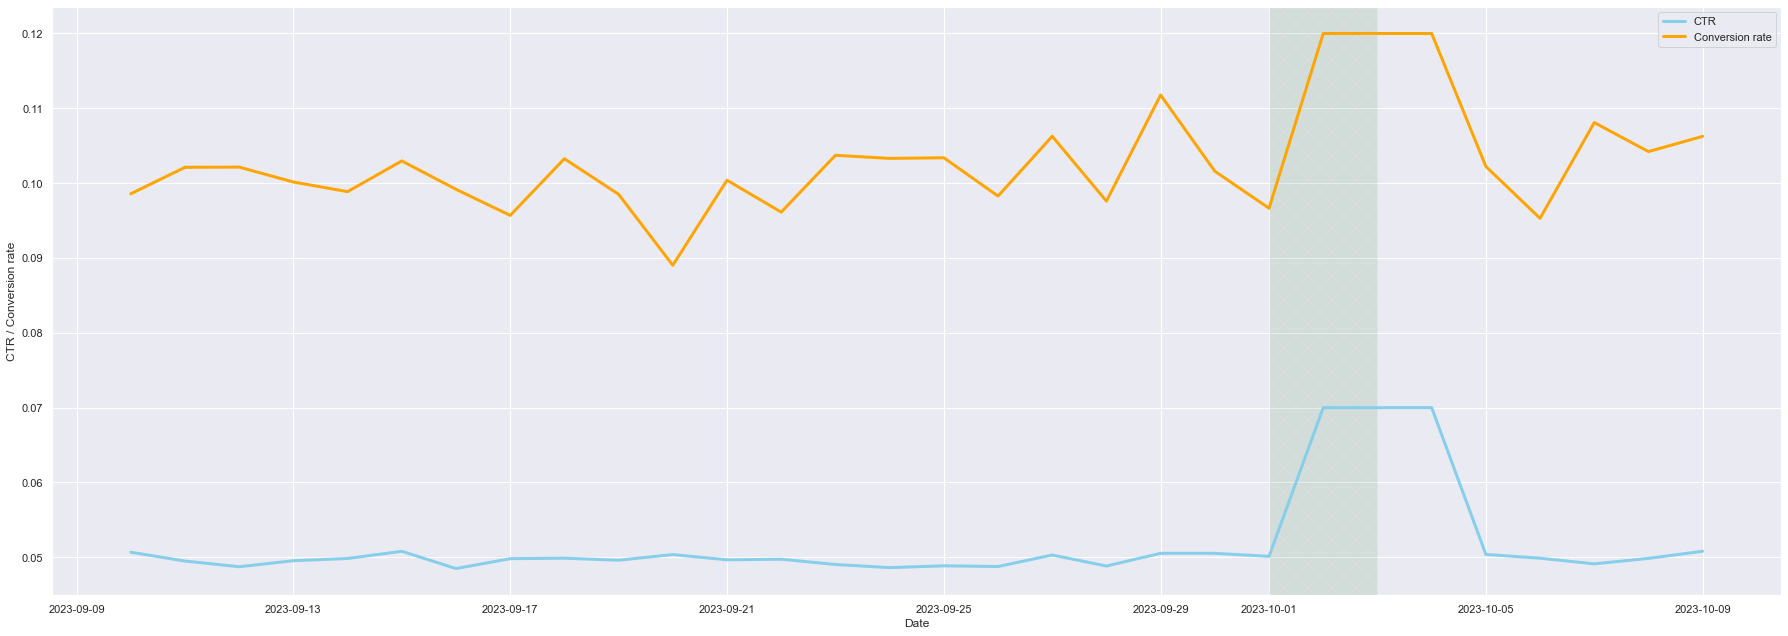

In [21]:
ctr = sns.lineplot(data=df,
                   x='date',
                   y='ctr',
                   color='skyblue',
                   linewidth = 3,
                   label='CTR'
                   )

conversion = sns.lineplot(data=df,
                          x='date',
                          y='conversion_rate',
                          color='orange',
                          linewidth = 3,
                          label='Conversion rate'
                          )

ctr.axvspan("2023-10-01", "2023-10-03",
            facecolor="darkgreen",
            hatch="x",
            alpha=0.1,
            label="Anomaly"
            )

ctr.set_xlabel("Date")
ctr.set_ylabel("CTR / Conversion rate")
plt.tight_layout()
plt.show()

Это пример статичного графика, которые отображает потенциальную корреляцию между CTR и конверсией, а также отображает зоны с аномалиями, выделил зелёным. То есть, если на графике с ломаными будут какие-то выбросы, то их можно легко проанализировать в деталях.

### График для продолжительности сессии/времени до клика на билеты из выдачи

Предполагаем, что средняя продолжительность сессии до клика на билет за последние 30 дней составила 2.8 минут с колебаниями от 1 до 4.6 минут. Но почему-то в определенные три дня она повысилась до 3.2 минут с максимальным средним значением 6.5.

In [22]:
mean_duration = df.time_to_click.mean()
min_duration = df.time_to_click.min()
max_duration = df.time_to_click.max()

df['time_to_click'][22:25] = 6.5

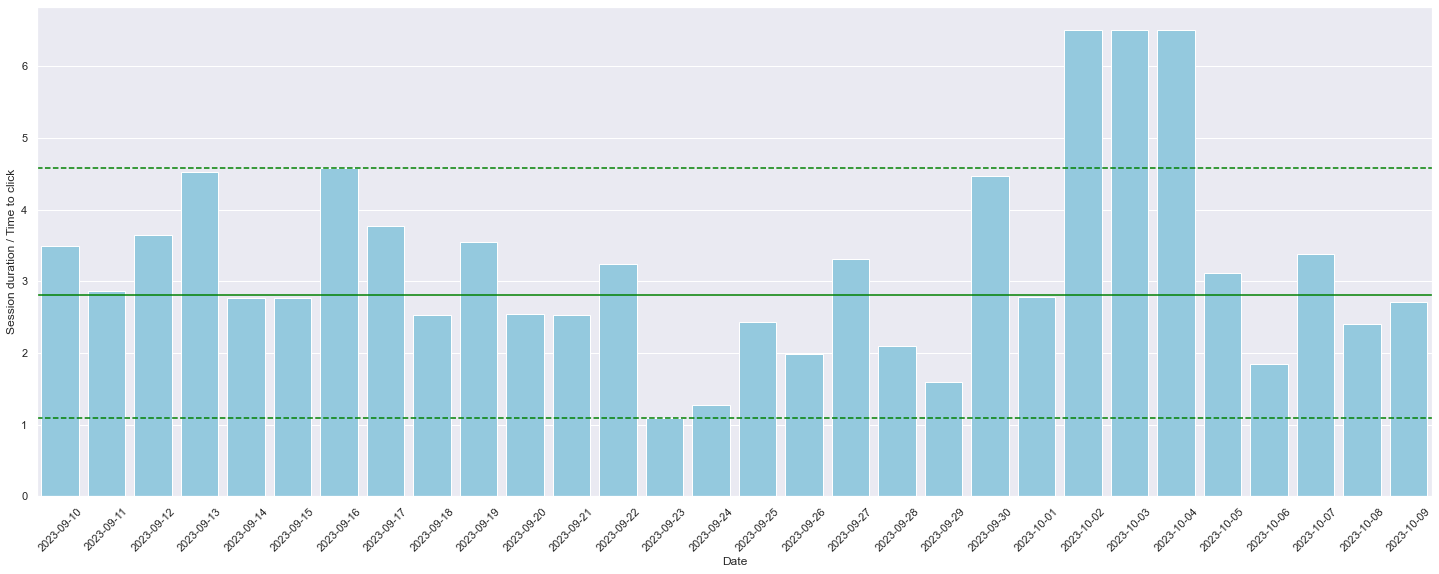

In [23]:
def duration_lineplot(mean, min, max):
    duration = sns.barplot(data=df,
                           x='date',
                           y='time_to_click',
                           color='skyblue'
                           )
    plt.axhline(y=mean, color='green')
    plt.axhline(y=min, color='green', ls='--')
    plt.axhline(y=max, color='green', ls='--')

    duration.set_xlabel("Date")
    duration.set_ylabel("Session duration / Time to click")
    plt.xticks(rotation=45)

    plt.show()

duration_lineplot(mean_duration, min_duration, max_duration)

Логика графика схожа с предыдущим, но здесь выдача более динамична, потому что принимает разные производные значения от метрик. Эти производные создают пороговые значения, за пределами которых продолжительность сессии и сама сессия должна быть изучена.

Таких графиков должно хватить для регулярных ежемесячных отчётов или просто для регулярной проверки системы. Примеры динамичных графиков или дашбордов есть у меня на GitHub!

## 3. Важные срезы
Во втором задании я сгенерировал агрегированные данные за день, что сильно упростило мне задачу для генерации данных, но на самом деле, в данные Avisales есть предугадываемые патерны.

**Время** -- наверняка количество пользователей на сайте меньше по ночам, что так же может сказаться на метриках.

**Сезонность** -- быть может летом, в какие-то наиболее туристические периоды, пользователи так же могут быть не очень рациональными и выбирать не "Самые..." билеты.

**Международные кризисы** -- как показала практика февраля 2022, личные риски могут нарушить рациональность поведения пользователя вне зависимости от работы модели.

**География** -- возможно регионы-города с плохим интернет покрытием могут исказить значение метрик.

**Устройства** -- наверняка UX пользователей с телефона отличается от опыта пользователей с лэптопа/компьютера.

**Партнёрские сайты** -- это уже на уровне теории заговоров, но возможно некоторые пользователи будут выбирать те билеты, которые продаются на сайте, где у клиента есть какие-то очки-баллы из программы лояльности.

## 4. Необходимые данные

**Данные о показах** --  Дата, время, тип устройства, география, позиция билеты (порядковый номер в выдаче).

**Данные о кликах** -- на какой билет был клик ("Самый..." или не "Самый..."), через сколько времени после показа, идентификатор пользователя.

**Данные о покупках** -- какой билет был куплен, какова была его стоимость, идентификатор пользователя, на какой сайт был совершён переход.

**Отзывы** -- результат мини опроса после перехода на партнёрский сайт, дата и время, идентификатор пользователя.

Как будто остальные метрики можно будет расчитать на основании указанных данных! И ещё нужны значения метрик за прошлые периоды, чтобы настроить графики и систему поимки аномалий.

## Резюме
Во втором задании я постарался продемонстрировать как можно, на уровне теории, оценивать работу скоринговой модели вложенной в главный продукт компании. На какие нюансы нужно обращать внимание и какие графики можно использовать для визуальной оценки работы модели. Как будто хотелось бы иметь на руках хотя бы не большой файл с данными, чтобы умозаключения были привязаны к реальным сюжетам!